## Training and Quality control for nuclear segmentation

StarDist uses a shape representation based on star-convex polygons for nuclei in an image to predict the presence and the shape of these nuclei. This network is based on an adapted U-Net network architecture. 

To train and test the network, we use a dataset from the 2018 DSB nuclear segmentation challenge as well as few more nuclei that we have labelled from widefield images of DAPI stained tissue sections. 

In [1]:
# import libraries 
import sys
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio as imio
import os

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.utils.tf import limit_gpu_memory

from stardist import fill_label_holes, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D

from src.utlis.data_augmentation import augmenter

from src.utlis.segmentation_stardist_model import segment_objects_stardist2d
from stardist.matching import matching_dataset


In [2]:
# setup the paths 
path_to_ground_truth_data=os.path.join(os.path.dirname(os.getcwd()),'ground_truths/')

path_to_raw_image = os.path.join(path_to_ground_truth_data,'raw_train/')
path_to_GT_labels = os.path.join(path_to_ground_truth_data,'GT_train/')
path_to_raw_image_test = os.path.join(path_to_ground_truth_data,'raw_test/') 
path_to_GT_labels_test = os.path.join(path_to_ground_truth_data,'GT_test/')

path_to_model = os.path.join(os.path.dirname(os.getcwd()),'models/')
output_dir = os.path.join(path_to_ground_truth_data,'model_pred_tissue_nuclear_segmentation/')

path_to_output_segmented_images_train = os.path.join(path_to_ground_truth_data,'Segmented_labels_train/')
path_to_output_segmented_images_test = os.path.join(path_to_ground_truth_data,'Segmented_labels_test/')

Path(output_dir).mkdir(parents=True, exist_ok=True)
Path(path_to_output_segmented_images_train).mkdir(parents=True, exist_ok=True)
Path(path_to_output_segmented_images_test).mkdir(parents=True, exist_ok=True)

In [3]:
#read in the training data which would of pairs of input image and label instances.
X = sorted(glob(path_to_raw_image +'*.tif'))
Y = sorted(glob(path_to_GT_labels +'*.tif'))
assert all(Path(x).name==Path(y).name for x,y in zip(X,Y))
X = list(map(imread,X))
Y = list(map(imread,Y))
#Normalize images and fill small label holes.
X = [normalize(x,1,99.8,axis=(0,1)) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]
#Split into train and validation datasets.
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train] 
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

100%|██████████| 453/453 [00:01<00:00, 249.38it/s]

number of images: 453
- training:       385
- validation:      68


In [4]:
#set up the configuration
conf = Config2D (
    n_rays       = 32,
    grid         = (2,2),
    use_gpu      = True and gputools_available(),
    n_channel_in = 1)
limit_gpu_memory(None, allow_growth=True)

#Setup and train the model
model = StarDist2D(conf, name='tissue_nuclear_segmentation', basedir=path_to_model)
history=model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
#optimize NMS threshold
model.optimize_thresholds(X_val, Y_val)
# convert the history.history dict to a pandas DataFrame:     
lossData = pd.DataFrame(history.history) 

Using default values: prob_thresh=0.5, nms_thresh=0.4.
Epoch 1/400
100/100 [==============================] - 10s 105ms/step - loss: 2.3303 - prob_loss: 0.3521 - dist_loss: 9.8908 - prob_kld: 0.2781 - dist_relevant_mae: 9.8903 - dist_relevant_mse: 194.5449 - val_loss: 1.8561 - val_prob_loss: 0.2791 - val_dist_loss: 7.8847 - val_prob_kld: 0.2087 - val_dist_relevant_mae: 7.8840 - val_dist_relevant_mse: 133.3001
Epoch 2/400
100/100 [==============================] - 7s 66ms/step - loss: 1.6271 - prob_loss: 0.2768 - dist_loss: 6.7518 - prob_kld: 0.2025 - dist_relevant_mae: 6.7509 - dist_relevant_mse: 96.9839 - val_loss: 1.8245 - val_prob_loss: 0.2919 - val_dist_loss: 7.6633 - val_prob_kld: 0.2214 - val_dist_relevant_mae: 7.6625 - val_dist_relevant_mse: 127.4322
Epoch 3/400
100/100 [==============================] - 6s 63ms/step - loss: 1.5293 - prob_loss: 0.2497 - dist_loss: 6.3980 - prob_kld: 0.1755 - dist_relevant_mae: 6.3969 - dist_relevant_mse: 88.0708 - val_loss: 1.5137 - val_prob_los

Epoch 24/400
100/100 [==============================] - 6s 61ms/step - loss: 0.5504 - prob_loss: 0.0900 - dist_loss: 2.3019 - prob_kld: 0.0161 - dist_relevant_mae: 2.3013 - dist_relevant_mse: 15.6864 - val_loss: 0.5266 - val_prob_loss: 0.0835 - val_dist_loss: 2.2156 - val_prob_kld: 0.0131 - val_dist_relevant_mae: 2.2150 - val_dist_relevant_mse: 14.7962
Epoch 25/400
100/100 [==============================] - 6s 60ms/step - loss: 0.5922 - prob_loss: 0.0892 - dist_loss: 2.5151 - prob_kld: 0.0147 - dist_relevant_mae: 2.5145 - dist_relevant_mse: 16.9785 - val_loss: 0.5639 - val_prob_loss: 0.0842 - val_dist_loss: 2.3983 - val_prob_kld: 0.0138 - val_dist_relevant_mae: 2.3978 - val_dist_relevant_mse: 16.0383
Epoch 26/400
100/100 [==============================] - 6s 62ms/step - loss: 0.5188 - prob_loss: 0.0870 - dist_loss: 2.1590 - prob_kld: 0.0141 - dist_relevant_mae: 2.1585 - dist_relevant_mse: 13.8374 - val_loss: 0.5173 - val_prob_loss: 0.0834 - val_dist_loss: 2.1693 - val_prob_kld: 0.0130 

100/100 [==============================] - 6s 59ms/step - loss: 0.4737 - prob_loss: 0.0856 - dist_loss: 1.9403 - prob_kld: 0.0121 - dist_relevant_mae: 1.9398 - dist_relevant_mse: 10.7365 - val_loss: 0.5563 - val_prob_loss: 0.0819 - val_dist_loss: 2.3720 - val_prob_kld: 0.0114 - val_dist_relevant_mae: 2.3714 - val_dist_relevant_mse: 12.4123
Epoch 48/400
100/100 [==============================] - 6s 60ms/step - loss: 0.4767 - prob_loss: 0.0854 - dist_loss: 1.9565 - prob_kld: 0.0121 - dist_relevant_mae: 1.9560 - dist_relevant_mse: 11.3303 - val_loss: 0.4552 - val_prob_loss: 0.0816 - val_dist_loss: 1.8678 - val_prob_kld: 0.0112 - val_dist_relevant_mae: 1.8673 - val_dist_relevant_mse: 10.4170
Epoch 49/400
100/100 [==============================] - 6s 59ms/step - loss: 0.4748 - prob_loss: 0.0856 - dist_loss: 1.9457 - prob_kld: 0.0121 - dist_relevant_mae: 1.9453 - dist_relevant_mse: 10.5716 - val_loss: 0.4872 - val_prob_loss: 0.0844 - val_dist_loss: 2.0141 - val_prob_kld: 0.0139 - val_dist_re

100/100 [==============================] - 6s 61ms/step - loss: 0.4418 - prob_loss: 0.0845 - dist_loss: 1.7865 - prob_kld: 0.0134 - dist_relevant_mae: 1.7860 - dist_relevant_mse: 9.4135 - val_loss: 0.4816 - val_prob_loss: 0.0825 - val_dist_loss: 1.9952 - val_prob_kld: 0.0121 - val_dist_relevant_mae: 1.9947 - val_dist_relevant_mse: 9.6399
Epoch 71/400
100/100 [==============================] - 6s 60ms/step - loss: 0.4281 - prob_loss: 0.0897 - dist_loss: 1.6921 - prob_kld: 0.0118 - dist_relevant_mae: 1.6917 - dist_relevant_mse: 8.9468 - val_loss: 0.4244 - val_prob_loss: 0.0809 - val_dist_loss: 1.7175 - val_prob_kld: 0.0104 - val_dist_relevant_mae: 1.7170 - val_dist_relevant_mse: 8.6267
Epoch 72/400
100/100 [==============================] - 6s 59ms/step - loss: 0.4319 - prob_loss: 0.0861 - dist_loss: 1.7287 - prob_kld: 0.0123 - dist_relevant_mae: 1.7282 - dist_relevant_mse: 9.0516 - val_loss: 0.4306 - val_prob_loss: 0.0808 - val_dist_loss: 1.7485 - val_prob_kld: 0.0104 - val_dist_relevan

100/100 [==============================] - 6s 61ms/step - loss: 0.4161 - prob_loss: 0.0846 - dist_loss: 1.6577 - prob_kld: 0.0109 - dist_relevant_mae: 1.6573 - dist_relevant_mse: 8.9293 - val_loss: 0.3869 - val_prob_loss: 0.0800 - val_dist_loss: 1.5345 - val_prob_kld: 0.0096 - val_dist_relevant_mae: 1.5341 - val_dist_relevant_mse: 7.2453
Epoch 94/400
100/100 [==============================] - 6s 61ms/step - loss: 0.3924 - prob_loss: 0.0862 - dist_loss: 1.5310 - prob_kld: 0.0107 - dist_relevant_mae: 1.5306 - dist_relevant_mse: 6.8964 - val_loss: 0.4051 - val_prob_loss: 0.0802 - val_dist_loss: 1.6249 - val_prob_kld: 0.0097 - val_dist_relevant_mae: 1.6245 - val_dist_relevant_mse: 7.8055
Epoch 95/400
100/100 [==============================] - 6s 60ms/step - loss: 0.3908 - prob_loss: 0.0821 - dist_loss: 1.5432 - prob_kld: 0.0106 - dist_relevant_mae: 1.5428 - dist_relevant_mse: 7.5304 - val_loss: 0.3954 - val_prob_loss: 0.0800 - val_dist_loss: 1.5772 - val_prob_kld: 0.0095 - val_dist_relevan

100/100 [==============================] - 6s 61ms/step - loss: 0.3815 - prob_loss: 0.0848 - dist_loss: 1.4835 - prob_kld: 0.0110 - dist_relevant_mae: 1.4830 - dist_relevant_mse: 6.7015 - val_loss: 0.4371 - val_prob_loss: 0.0800 - val_dist_loss: 1.7855 - val_prob_kld: 0.0096 - val_dist_relevant_mae: 1.7851 - val_dist_relevant_mse: 8.3514
Epoch 117/400
100/100 [==============================] - 6s 62ms/step - loss: 0.3952 - prob_loss: 0.0820 - dist_loss: 1.5660 - prob_kld: 0.0101 - dist_relevant_mae: 1.5656 - dist_relevant_mse: 7.1030 - val_loss: 0.3921 - val_prob_loss: 0.0809 - val_dist_loss: 1.5558 - val_prob_kld: 0.0105 - val_dist_relevant_mae: 1.5554 - val_dist_relevant_mse: 7.2936
Epoch 118/400
100/100 [==============================] - 6s 60ms/step - loss: 0.3876 - prob_loss: 0.0876 - dist_loss: 1.5000 - prob_kld: 0.0108 - dist_relevant_mae: 1.4994 - dist_relevant_mse: 7.0598 - val_loss: 0.4151 - val_prob_loss: 0.0804 - val_dist_loss: 1.6732 - val_prob_kld: 0.0100 - val_dist_relev

100/100 [==============================] - 6s 59ms/step - loss: 0.3651 - prob_loss: 0.0837 - dist_loss: 1.4067 - prob_kld: 0.0096 - dist_relevant_mae: 1.4063 - dist_relevant_mse: 6.3798 - val_loss: 0.4138 - val_prob_loss: 0.0835 - val_dist_loss: 1.6515 - val_prob_kld: 0.0130 - val_dist_relevant_mae: 1.6511 - val_dist_relevant_mse: 7.8226
Epoch 140/400
100/100 [==============================] - 6s 61ms/step - loss: 0.4047 - prob_loss: 0.0856 - dist_loss: 1.5955 - prob_kld: 0.0116 - dist_relevant_mae: 1.5951 - dist_relevant_mse: 7.9770 - val_loss: 0.3887 - val_prob_loss: 0.0796 - val_dist_loss: 1.5456 - val_prob_kld: 0.0092 - val_dist_relevant_mae: 1.5452 - val_dist_relevant_mse: 7.0073
Epoch 141/400
100/100 [==============================] - 6s 64ms/step - loss: 0.3829 - prob_loss: 0.0829 - dist_loss: 1.5000 - prob_kld: 0.0095 - dist_relevant_mae: 1.4996 - dist_relevant_mse: 7.2362 - val_loss: 0.3748 - val_prob_loss: 0.0795 - val_dist_loss: 1.4769 - val_prob_kld: 0.0090 - val_dist_relev

100/100 [==============================] - 6s 58ms/step - loss: 0.3584 - prob_loss: 0.0805 - dist_loss: 1.3895 - prob_kld: 0.0096 - dist_relevant_mae: 1.3891 - dist_relevant_mse: 6.0330 - val_loss: 0.3718 - val_prob_loss: 0.0800 - val_dist_loss: 1.4587 - val_prob_kld: 0.0096 - val_dist_relevant_mae: 1.4583 - val_dist_relevant_mse: 6.5847
Epoch 163/400
100/100 [==============================] - 6s 62ms/step - loss: 0.3647 - prob_loss: 0.0851 - dist_loss: 1.3982 - prob_kld: 0.0103 - dist_relevant_mae: 1.3977 - dist_relevant_mse: 5.9803 - val_loss: 0.3802 - val_prob_loss: 0.0798 - val_dist_loss: 1.5018 - val_prob_kld: 0.0094 - val_dist_relevant_mae: 1.5012 - val_dist_relevant_mse: 6.8685
Epoch 164/400
100/100 [==============================] - 6s 62ms/step - loss: 0.3581 - prob_loss: 0.0826 - dist_loss: 1.3773 - prob_kld: 0.0096 - dist_relevant_mae: 1.3768 - dist_relevant_mse: 6.3251 - val_loss: 0.4597 - val_prob_loss: 0.0797 - val_dist_loss: 1.8999 - val_prob_kld: 0.0093 - val_dist_relev

100/100 [==============================] - 6s 61ms/step - loss: 0.3593 - prob_loss: 0.0852 - dist_loss: 1.3705 - prob_kld: 0.0100 - dist_relevant_mae: 1.3700 - dist_relevant_mse: 6.2415 - val_loss: 0.3656 - val_prob_loss: 0.0794 - val_dist_loss: 1.4307 - val_prob_kld: 0.0090 - val_dist_relevant_mae: 1.4303 - val_dist_relevant_mse: 6.3379
Epoch 186/400
100/100 [==============================] - 6s 61ms/step - loss: 0.3415 - prob_loss: 0.0844 - dist_loss: 1.2854 - prob_kld: 0.0092 - dist_relevant_mae: 1.2850 - dist_relevant_mse: 5.4416 - val_loss: 0.3597 - val_prob_loss: 0.0797 - val_dist_loss: 1.4000 - val_prob_kld: 0.0092 - val_dist_relevant_mae: 1.3995 - val_dist_relevant_mse: 6.1671
Epoch 187/400
100/100 [==============================] - 6s 62ms/step - loss: 0.3573 - prob_loss: 0.0835 - dist_loss: 1.3691 - prob_kld: 0.0091 - dist_relevant_mae: 1.3687 - dist_relevant_mse: 6.0625 - val_loss: 0.3949 - val_prob_loss: 0.0801 - val_dist_loss: 1.5740 - val_prob_kld: 0.0097 - val_dist_relev

100/100 [==============================] - 6s 60ms/step - loss: 0.3393 - prob_loss: 0.0821 - dist_loss: 1.2858 - prob_kld: 0.0086 - dist_relevant_mae: 1.2854 - dist_relevant_mse: 5.1899 - val_loss: 0.3492 - val_prob_loss: 0.0795 - val_dist_loss: 1.3482 - val_prob_kld: 0.0091 - val_dist_relevant_mae: 1.3478 - val_dist_relevant_mse: 5.8546
Epoch 209/400
100/100 [==============================] - 6s 61ms/step - loss: 0.3396 - prob_loss: 0.0834 - dist_loss: 1.2809 - prob_kld: 0.0084 - dist_relevant_mae: 1.2805 - dist_relevant_mse: 5.4572 - val_loss: 0.3565 - val_prob_loss: 0.0795 - val_dist_loss: 1.3851 - val_prob_kld: 0.0090 - val_dist_relevant_mae: 1.3848 - val_dist_relevant_mse: 6.2929
Epoch 210/400
100/100 [==============================] - 6s 64ms/step - loss: 0.3306 - prob_loss: 0.0831 - dist_loss: 1.2375 - prob_kld: 0.0085 - dist_relevant_mae: 1.2371 - dist_relevant_mse: 4.7584 - val_loss: 0.4059 - val_prob_loss: 0.0801 - val_dist_loss: 1.6290 - val_prob_kld: 0.0096 - val_dist_relev

100/100 [==============================] - 6s 59ms/step - loss: 0.3263 - prob_loss: 0.0823 - dist_loss: 1.2200 - prob_kld: 0.0083 - dist_relevant_mae: 1.2196 - dist_relevant_mse: 4.9547 - val_loss: 0.3853 - val_prob_loss: 0.0798 - val_dist_loss: 1.5272 - val_prob_kld: 0.0094 - val_dist_relevant_mae: 1.5268 - val_dist_relevant_mse: 6.8493
Epoch 232/400
100/100 [==============================] - 6s 60ms/step - loss: 0.3273 - prob_loss: 0.0821 - dist_loss: 1.2257 - prob_kld: 0.0087 - dist_relevant_mae: 1.2253 - dist_relevant_mse: 4.8048 - val_loss: 0.3589 - val_prob_loss: 0.0796 - val_dist_loss: 1.3969 - val_prob_kld: 0.0091 - val_dist_relevant_mae: 1.3964 - val_dist_relevant_mse: 6.2762
Epoch 233/400
100/100 [==============================] - 6s 60ms/step - loss: 0.3207 - prob_loss: 0.0804 - dist_loss: 1.2012 - prob_kld: 0.0087 - dist_relevant_mae: 1.2007 - dist_relevant_mse: 4.8529 - val_loss: 0.3601 - val_prob_loss: 0.0816 - val_dist_loss: 1.3926 - val_prob_kld: 0.0112 - val_dist_relev

100/100 [==============================] - 6s 62ms/step - loss: 0.3083 - prob_loss: 0.0801 - dist_loss: 1.1410 - prob_kld: 0.0078 - dist_relevant_mae: 1.1407 - dist_relevant_mse: 4.0538 - val_loss: 0.3596 - val_prob_loss: 0.0799 - val_dist_loss: 1.3987 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.3983 - val_dist_relevant_mse: 6.6920
Epoch 255/400
100/100 [==============================] - 6s 61ms/step - loss: 0.3124 - prob_loss: 0.0822 - dist_loss: 1.1509 - prob_kld: 0.0081 - dist_relevant_mae: 1.1505 - dist_relevant_mse: 4.3148 - val_loss: 0.3462 - val_prob_loss: 0.0794 - val_dist_loss: 1.3341 - val_prob_kld: 0.0090 - val_dist_relevant_mae: 1.3337 - val_dist_relevant_mse: 5.5725
Epoch 256/400
100/100 [==============================] - 6s 59ms/step - loss: 0.3198 - prob_loss: 0.0823 - dist_loss: 1.1875 - prob_kld: 0.0082 - dist_relevant_mae: 1.1871 - dist_relevant_mse: 4.5399 - val_loss: 0.3589 - val_prob_loss: 0.0796 - val_dist_loss: 1.3966 - val_prob_kld: 0.0092 - val_dist_relev

100/100 [==============================] - 6s 58ms/step - loss: 0.3168 - prob_loss: 0.0822 - dist_loss: 1.1730 - prob_kld: 0.0084 - dist_relevant_mae: 1.1726 - dist_relevant_mse: 4.5760 - val_loss: 0.3577 - val_prob_loss: 0.0800 - val_dist_loss: 1.3885 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.3881 - val_dist_relevant_mse: 6.1952
Epoch 278/400
100/100 [==============================] - 6s 60ms/step - loss: 0.3120 - prob_loss: 0.0835 - dist_loss: 1.1429 - prob_kld: 0.0077 - dist_relevant_mae: 1.1425 - dist_relevant_mse: 4.5432 - val_loss: 0.3437 - val_prob_loss: 0.0794 - val_dist_loss: 1.3216 - val_prob_kld: 0.0089 - val_dist_relevant_mae: 1.3212 - val_dist_relevant_mse: 5.8127
Epoch 279/400
100/100 [==============================] - 6s 60ms/step - loss: 0.3173 - prob_loss: 0.0796 - dist_loss: 1.1886 - prob_kld: 0.0074 - dist_relevant_mae: 1.1883 - dist_relevant_mse: 4.6277 - val_loss: 0.3477 - val_prob_loss: 0.0800 - val_dist_loss: 1.3383 - val_prob_kld: 0.0096 - val_dist_relev

100/100 [==============================] - 6s 57ms/step - loss: 0.3148 - prob_loss: 0.0851 - dist_loss: 1.1487 - prob_kld: 0.0080 - dist_relevant_mae: 1.1483 - dist_relevant_mse: 4.3423 - val_loss: 0.3479 - val_prob_loss: 0.0795 - val_dist_loss: 1.3422 - val_prob_kld: 0.0091 - val_dist_relevant_mae: 1.3418 - val_dist_relevant_mse: 5.9952
Epoch 301/400
100/100 [==============================] - 6s 61ms/step - loss: 0.2969 - prob_loss: 0.0783 - dist_loss: 1.0930 - prob_kld: 0.0074 - dist_relevant_mae: 1.0926 - dist_relevant_mse: 3.8205 - val_loss: 0.3638 - val_prob_loss: 0.0799 - val_dist_loss: 1.4194 - val_prob_kld: 0.0094 - val_dist_relevant_mae: 1.4190 - val_dist_relevant_mse: 6.1561
Epoch 302/400
100/100 [==============================] - 6s 59ms/step - loss: 0.3168 - prob_loss: 0.0826 - dist_loss: 1.1710 - prob_kld: 0.0079 - dist_relevant_mae: 1.1706 - dist_relevant_mse: 4.8777 - val_loss: 0.3416 - val_prob_loss: 0.0794 - val_dist_loss: 1.3112 - val_prob_kld: 0.0090 - val_dist_relev

100/100 [==============================] - 6s 60ms/step - loss: 0.3062 - prob_loss: 0.0815 - dist_loss: 1.1233 - prob_kld: 0.0075 - dist_relevant_mae: 1.1229 - dist_relevant_mse: 4.6257 - val_loss: 0.3512 - val_prob_loss: 0.0798 - val_dist_loss: 1.3572 - val_prob_kld: 0.0094 - val_dist_relevant_mae: 1.3568 - val_dist_relevant_mse: 6.0401
Epoch 324/400
100/100 [==============================] - 6s 59ms/step - loss: 0.2979 - prob_loss: 0.0804 - dist_loss: 1.0872 - prob_kld: 0.0070 - dist_relevant_mae: 1.0868 - dist_relevant_mse: 3.8148 - val_loss: 0.3428 - val_prob_loss: 0.0796 - val_dist_loss: 1.3161 - val_prob_kld: 0.0092 - val_dist_relevant_mae: 1.3157 - val_dist_relevant_mse: 5.7184
Epoch 325/400
100/100 [==============================] - 6s 58ms/step - loss: 0.3056 - prob_loss: 0.0779 - dist_loss: 1.1387 - prob_kld: 0.0070 - dist_relevant_mae: 1.1383 - dist_relevant_mse: 4.3253 - val_loss: 0.3429 - val_prob_loss: 0.0797 - val_dist_loss: 1.3162 - val_prob_kld: 0.0092 - val_dist_relev

100/100 [==============================] - 6s 57ms/step - loss: 0.2994 - prob_loss: 0.0804 - dist_loss: 1.0947 - prob_kld: 0.0078 - dist_relevant_mae: 1.0943 - dist_relevant_mse: 3.8890 - val_loss: 0.3436 - val_prob_loss: 0.0815 - val_dist_loss: 1.3103 - val_prob_kld: 0.0111 - val_dist_relevant_mae: 1.3099 - val_dist_relevant_mse: 5.5127
Epoch 347/400
100/100 [==============================] - 5s 55ms/step - loss: 0.2977 - prob_loss: 0.0826 - dist_loss: 1.0755 - prob_kld: 0.0070 - dist_relevant_mae: 1.0751 - dist_relevant_mse: 3.9931 - val_loss: 0.3503 - val_prob_loss: 0.0797 - val_dist_loss: 1.3533 - val_prob_kld: 0.0092 - val_dist_relevant_mae: 1.3529 - val_dist_relevant_mse: 6.0021
Epoch 348/400
100/100 [==============================] - 6s 57ms/step - loss: 0.2932 - prob_loss: 0.0826 - dist_loss: 1.0529 - prob_kld: 0.0077 - dist_relevant_mae: 1.0525 - dist_relevant_mse: 3.5346 - val_loss: 0.3502 - val_prob_loss: 0.0802 - val_dist_loss: 1.3503 - val_prob_kld: 0.0097 - val_dist_relev

100/100 [==============================] - 6s 57ms/step - loss: 0.2879 - prob_loss: 0.0803 - dist_loss: 1.0377 - prob_kld: 0.0066 - dist_relevant_mae: 1.0373 - dist_relevant_mse: 3.6115 - val_loss: 0.3407 - val_prob_loss: 0.0794 - val_dist_loss: 1.3063 - val_prob_kld: 0.0090 - val_dist_relevant_mae: 1.3059 - val_dist_relevant_mse: 5.5665
Epoch 370/400
100/100 [==============================] - 6s 58ms/step - loss: 0.3032 - prob_loss: 0.0801 - dist_loss: 1.1154 - prob_kld: 0.0071 - dist_relevant_mae: 1.1150 - dist_relevant_mse: 4.0413 - val_loss: 0.3825 - val_prob_loss: 0.0800 - val_dist_loss: 1.5128 - val_prob_kld: 0.0095 - val_dist_relevant_mae: 1.5124 - val_dist_relevant_mse: 6.4921
Epoch 371/400
100/100 [==============================] - 6s 59ms/step - loss: 0.3066 - prob_loss: 0.0814 - dist_loss: 1.1257 - prob_kld: 0.0076 - dist_relevant_mae: 1.1253 - dist_relevant_mse: 4.6607 - val_loss: 0.3510 - val_prob_loss: 0.0800 - val_dist_loss: 1.3551 - val_prob_kld: 0.0096 - val_dist_relev

100/100 [==============================] - 6s 58ms/step - loss: 0.2971 - prob_loss: 0.0790 - dist_loss: 1.0905 - prob_kld: 0.0070 - dist_relevant_mae: 1.0901 - dist_relevant_mse: 3.7429 - val_loss: 0.3589 - val_prob_loss: 0.0797 - val_dist_loss: 1.3960 - val_prob_kld: 0.0092 - val_dist_relevant_mae: 1.3956 - val_dist_relevant_mse: 6.1523
Epoch 393/400
100/100 [==============================] - 6s 60ms/step - loss: 0.2998 - prob_loss: 0.0812 - dist_loss: 1.0931 - prob_kld: 0.0069 - dist_relevant_mae: 1.0927 - dist_relevant_mse: 4.0633 - val_loss: 0.3383 - val_prob_loss: 0.0798 - val_dist_loss: 1.2921 - val_prob_kld: 0.0094 - val_dist_relevant_mae: 1.2917 - val_dist_relevant_mse: 5.6907
Epoch 394/400
100/100 [==============================] - 6s 59ms/step - loss: 0.2999 - prob_loss: 0.0823 - dist_loss: 1.0878 - prob_kld: 0.0070 - dist_relevant_mae: 1.0875 - dist_relevant_mse: 3.7366 - val_loss: 0.3468 - val_prob_loss: 0.0802 - val_dist_loss: 1.3334 - val_prob_kld: 0.0097 - val_dist_relev

NMS threshold = 0.5:  75%|███████▌  | 15/20 [00:45<00:15,  3.03s/it, 0.522 -> 0.755]


Using optimized values: prob_thresh=0.507725, nms_thresh=0.3.
Saving to 'thresholds.json'.


### Quality checks 

We check the visualise the loss curves for the training and validation sets to make sure that the training is complete.

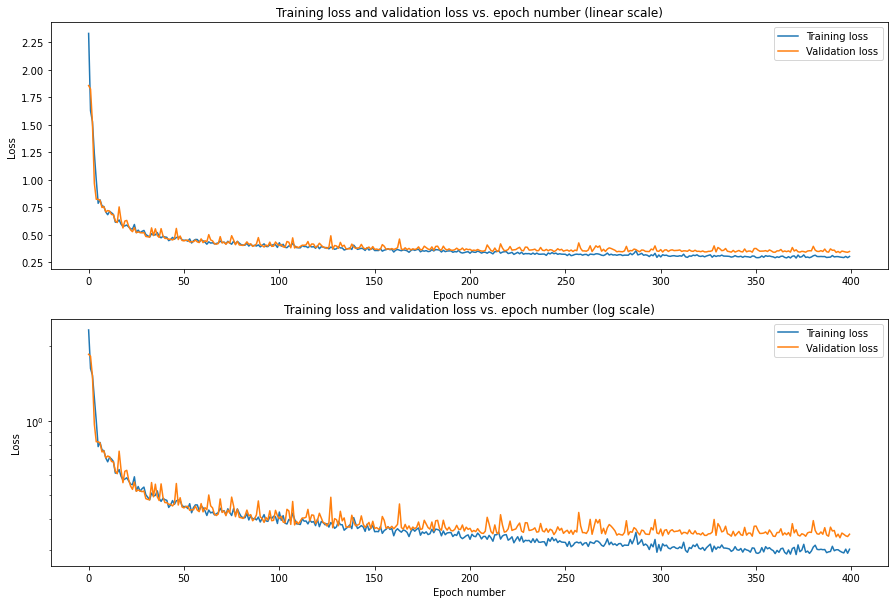

In [5]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(range(400),lossData['loss'], label='Training loss')
plt.plot(range(400),lossData['val_loss'], label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (linear scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()

plt.subplot(2,1,2)
plt.semilogy(range(400),lossData['loss'], label='Training loss')
plt.semilogy(range(400),lossData['val_loss'], label='Validation loss')
plt.title('Training loss and validation loss vs. epoch number (log scale)')
plt.ylabel('Loss')
plt.xlabel('Epoch number')
plt.legend()
plt.show()

lossData.to_csv(output_dir+"training_losses.csv")

Further, we also obtain object level errors using IoU based metrics 

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.507725, nms_thresh=0.3.


100%|██████████| 9/9 [00:17<00:00,  1.99s/it]


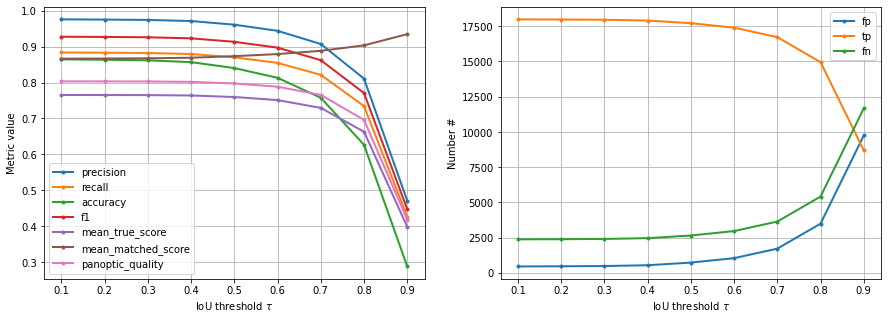

In [6]:
#perform the segmentation task
segment_objects_stardist2d(image_dir = path_to_raw_image,
                           output_dir_labels = path_to_output_segmented_images_train,
                           use_pretrained = False, 
                           output_dir_ijroi = False,
                           model_name='tissue_nuclear_segmentation',
                           model_dir = path_to_model)
#read in the images and results 
X = sorted(glob(path_to_raw_image+"*.tif"))
Y = sorted(glob(path_to_GT_labels+"*.tif"))
Y_pred = sorted(glob(path_to_output_segmented_images_train +"*.tif"))
X = list(map(imread,X))
Y = list(map(imread,Y))
Y_pred = list(map(imread,Y_pred))

#Compute the segmentation efficiency metrics for the whole dataset
#IoU thresholds to compute
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();
seg_efficiency_tot=pd.DataFrame(stats)
seg_efficiency_tot.to_csv(output_dir+"train_segmentation_efficiencies_whole_dataset.csv")

Finally we use a test dataset of images that the model has not see evaluate the model

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.507725, nms_thresh=0.3.


100%|██████████| 9/9 [00:03<00:00,  2.73it/s]


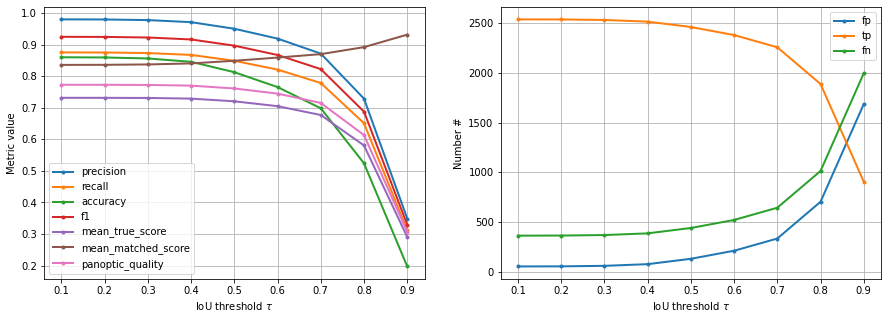

In [7]:
#perform the segmentation task
segment_objects_stardist2d(image_dir = path_to_raw_image_test,
                           output_dir_labels = path_to_output_segmented_images_test,
                           use_pretrained = False,
                           output_dir_ijroi = False,
                           model_name='tissue_nuclear_segmentation',
                           model_dir = path_to_model)
#read in the images and results 
X = sorted(glob(path_to_raw_image_test+"*.tif"))
Y = sorted(glob(path_to_GT_labels_test+"*.tif"))
Y_pred = sorted(glob(path_to_output_segmented_images_test +"*.tif"))
X = list(map(imread,X))
Y = list(map(imread,Y))
Y_pred = list(map(imread,Y_pred))

#Compute the segmentation efficiency metrics for the whole dataset
#IoU thresholds to compute
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y, Y_pred, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax1.set_xlabel(r'IoU threshold $\tau$')
    ax1.set_ylabel('Metric value')
    ax1.grid()
    ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
    ax2.set_xlabel(r'IoU threshold $\tau$')
    ax2.set_ylabel('Number #')
    ax2.grid()
    ax2.legend();
#Save the results
seg_efficiency_tot.to_csv(output_dir+"test_segmentation_efficiencies_whole_dataset.csv")

In [9]:
#IoU thresholds to compute
thresholds =[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
pd.DataFrame( {"Level" : ['whole_dataset'],
               "Recall_0.7_IoU" : [seg_efficiency_tot['recall'][thresholds.index(0.7)]],
               "Average_F1" : [np.mean(seg_efficiency_tot['f1'])],
               "Accuracy" : [seg_efficiency_tot['accuracy'][thresholds.index(0.7)]]})


,Level,Recall_0.7_IoU,Average_F1,Accuracy
0,whole_dataset,0.821392,0.843675,0.757621
